# Titanic attempt 4 (Hopefully final)

##imports needed

In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn import svm #support vector Machine
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics #accuracy measure
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

## Importing datasets

In [32]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
dataset = train.append(test)

train_analysis = pd.read_csv("train.csv")
test_analysis = pd.read_csv("test.csv")
dataset_analysis = train.append(test)

## data analysis

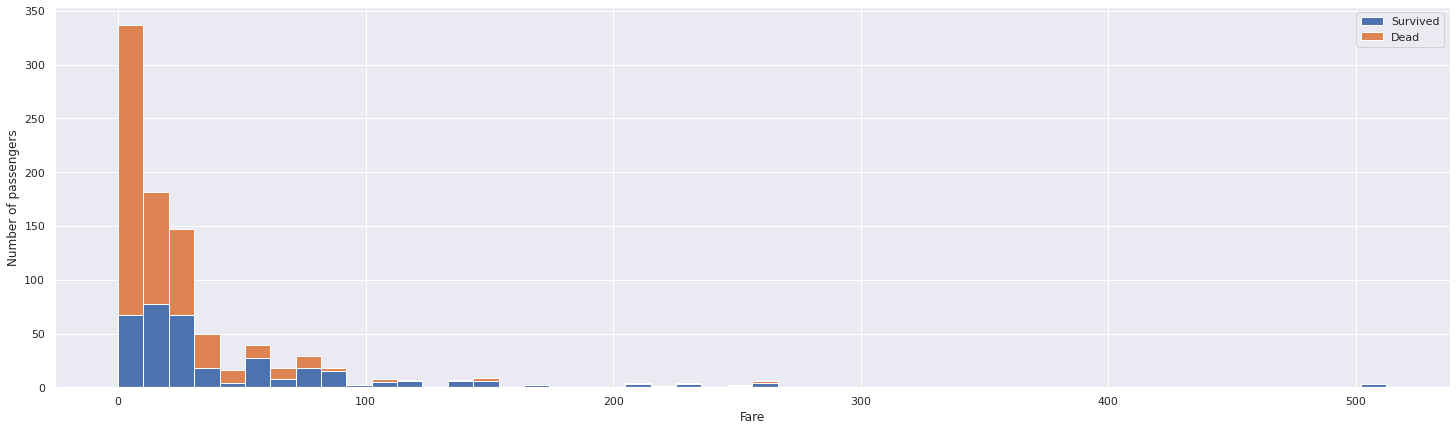

In [33]:
fig = plt.figure(figsize=(25, 7))
plt.hist([train_analysis[train_analysis['Survived'] == 1]['Fare'], train_analysis[train_analysis['Survived'] == 0]['Fare']], 
         stacked=True, bins = 50, label = ['Survived','Dead'])
plt.xlabel('Fare')
plt.ylabel('Number of passengers')
plt.legend();

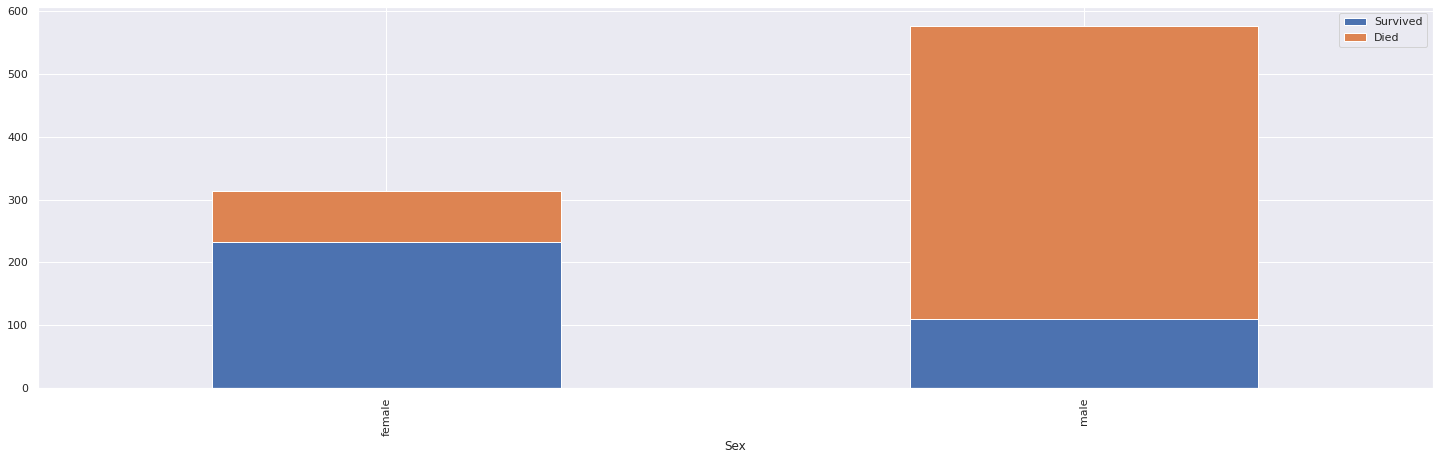

In [34]:
train_analysis['Age'] = train_analysis['Age'].fillna(train['Age'].median())
train_analysis['Died'] = 1 - train_analysis['Survived']
train_analysis.groupby('Sex').agg('sum')[['Survived', 'Died']].plot(kind='bar', figsize=(25, 7),
                                                          stacked=True);

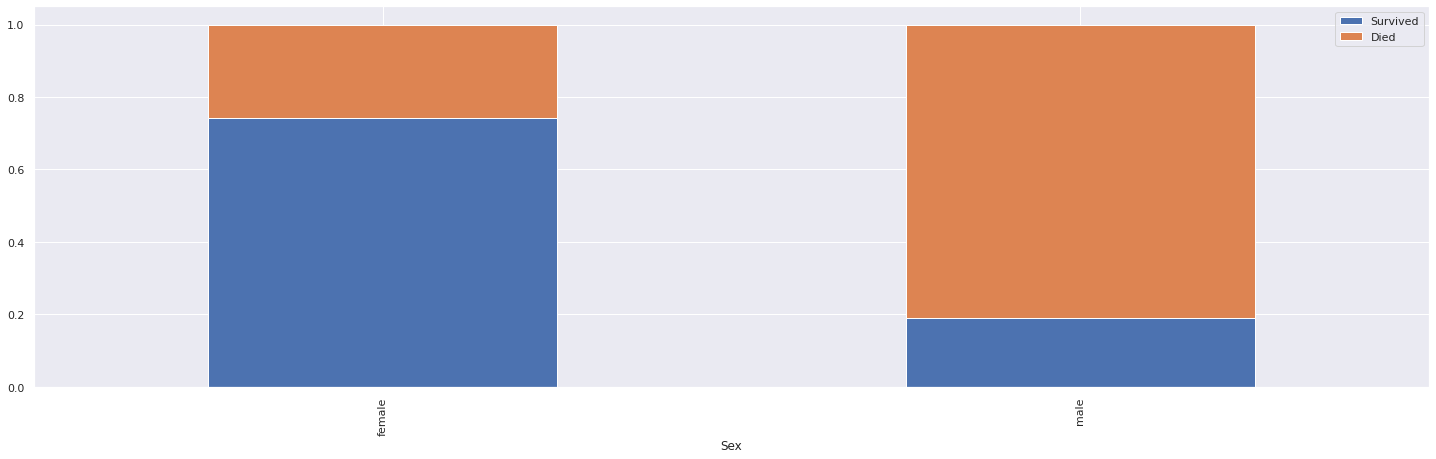

In [35]:
train_analysis.groupby('Sex').agg('mean')[['Survived', 'Died']].plot(kind='bar', figsize=(25, 7),
                                                          stacked=True);

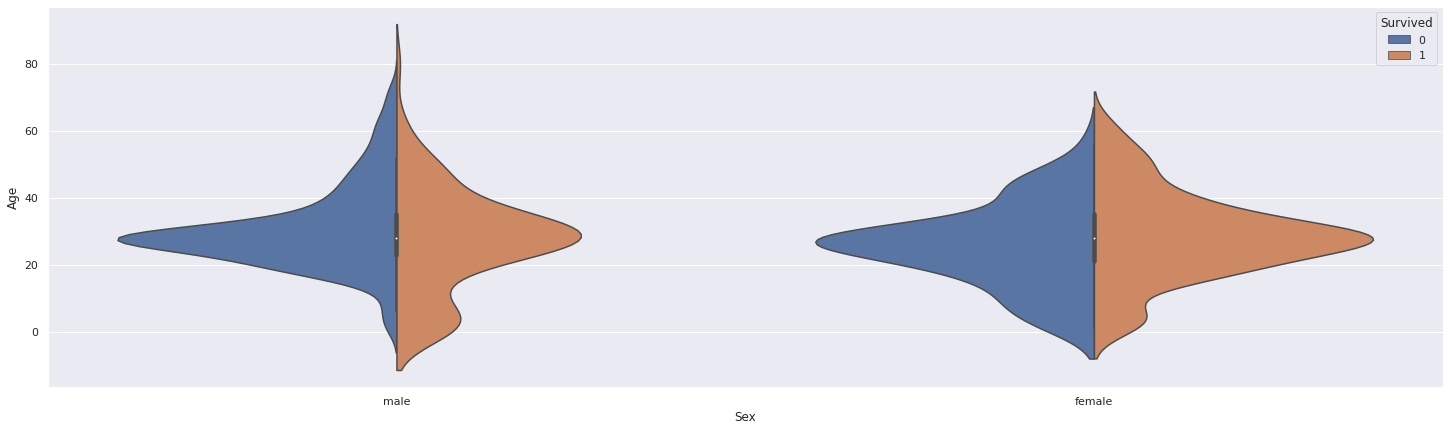

In [36]:
fig = plt.figure(figsize=(25, 7))
sns.violinplot(x='Sex', y='Age', 
               hue='Survived', data=train_analysis, 
               split=True,
               );

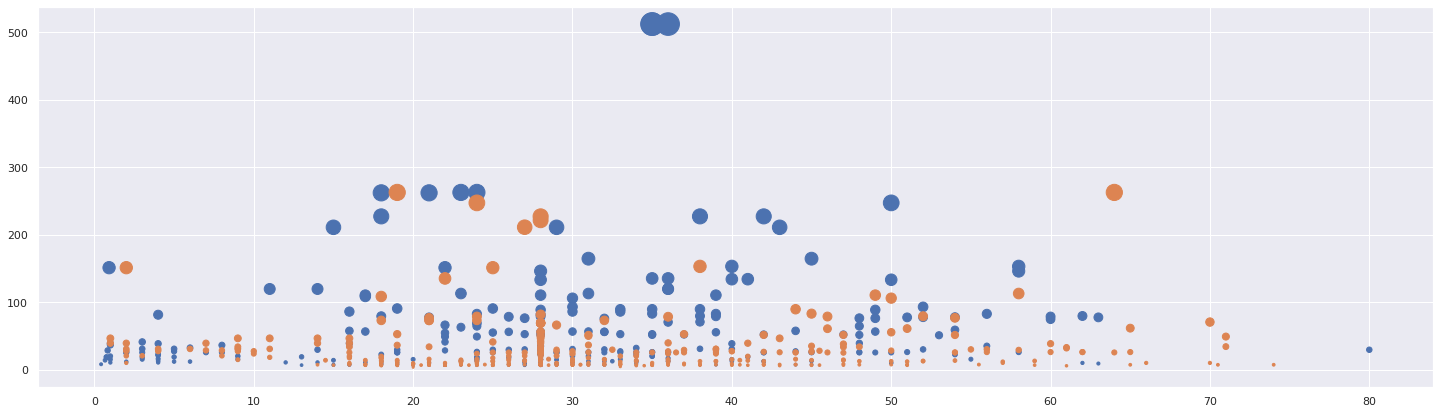

In [37]:
plt.figure(figsize=(25, 7))
plo = plt.subplot()

plo.scatter(train_analysis[train_analysis['Survived'] == 1]['Age'], train_analysis[train_analysis['Survived'] == 1]['Fare'], s=train_analysis[train_analysis['Survived'] == 1]['Fare'])
plo.scatter(train_analysis[train_analysis['Survived'] == 0]['Age'], train_analysis[train_analysis['Survived'] == 0]['Fare'], s=train_analysis[train_analysis['Survived'] == 0]['Fare']);

#x axis = age
# y = fare

In [38]:
sns.set()
def create_chart(feature):
    lived = train_analysis[train_analysis['Survived']==1][feature].value_counts()
    died = train_analysis[train_analysis['Survived']==0][feature].value_counts()
    df = pd.DataFrame([lived,died])
    df.index = ['Lived','Died']
    df.plot(kind='bar',stacked=True, figsize=(10,5))
    print(df)

           0      1
Lived    NaN  342.0
Died   549.0    NaN


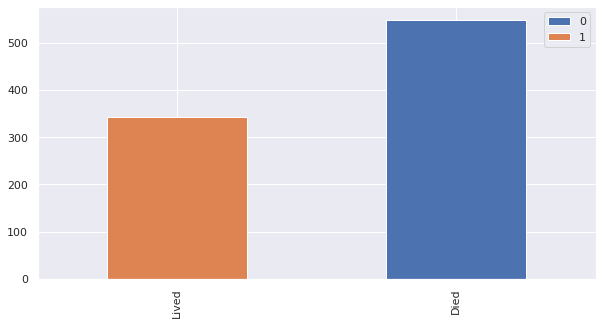

In [39]:
create_chart("Survived")

         1   2    3
Lived  136  87  119
Died    80  97  372


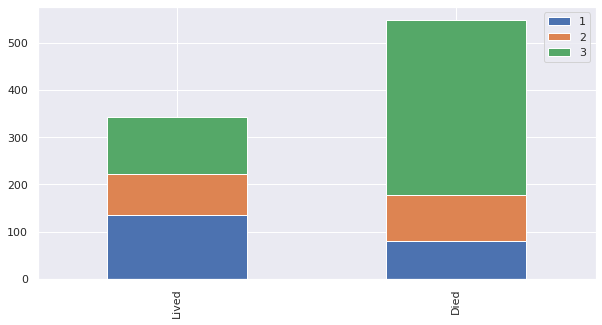

In [40]:
create_chart("Pclass")

       female  male
Lived     233   109
Died       81   468


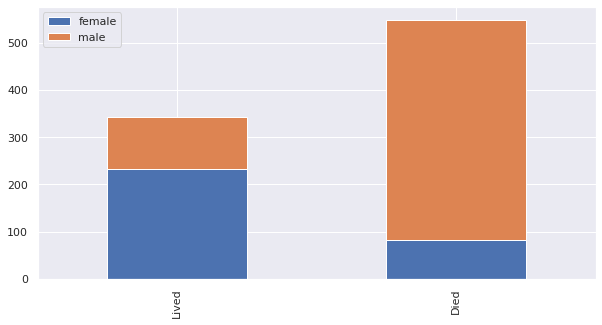

In [41]:
create_chart("Sex")

           0      1     2     3     4    5    8
Lived  210.0  112.0  13.0   4.0   3.0  NaN  NaN
Died   398.0   97.0  15.0  12.0  15.0  5.0  7.0


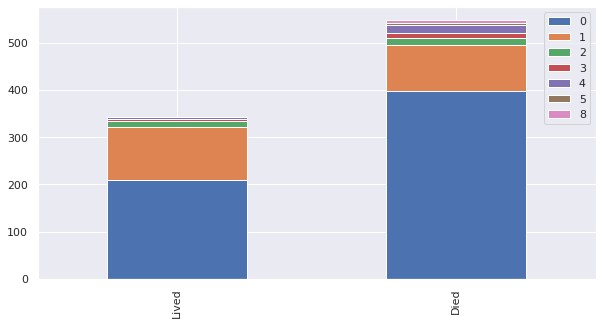

In [42]:
create_chart('SibSp')

           0     1     2    3    4    5    6
Lived  233.0  65.0  40.0  3.0  NaN  1.0  NaN
Died   445.0  53.0  40.0  2.0  4.0  4.0  1.0


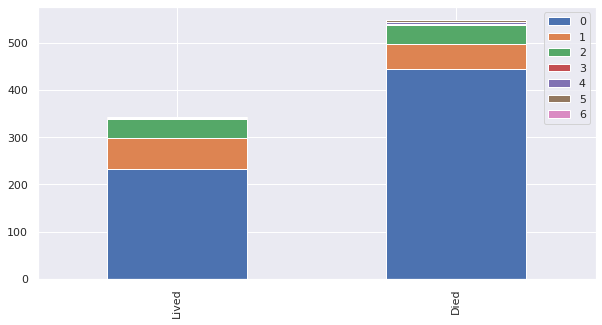

In [43]:
create_chart('Parch')

         S   C   Q
Lived  217  93  30
Died   427  75  47


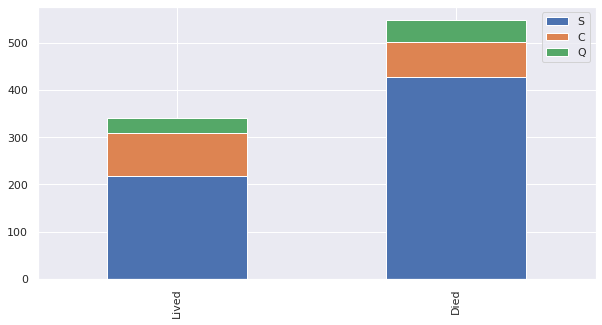

In [44]:
create_chart('Embarked')

##Modifying data based of analysis findings

###Using title to fill in NaN ages (Title dropped afterwards)

In [45]:
dataset['Title'] = dataset['Name']
for name_string in dataset['Name']:
    dataset['Title'] = dataset['Name'].str.extract('([A-Za-z]+)\.', expand=True)

mapping = {'Mlle': 'Miss',
           'Major': 'Mr',
           'Col': 'Mr',
           'Sir': 'Mr',
           'Don': 'Mr',
           'Mme': 'Miss',
          'Jonkheer': 'Mr',
           'Lady': 'Mrs',
           'Capt': 'Mr',
           'Countess': 'Mrs',
           'Ms': 'Miss',
           'Dona': 'Mrs'
           }

dataset.replace({'Title': mapping}, inplace=True)
titles = ['Dr', 'Master', 'Miss', 'Mr', 'Mrs', 'Rev']
for t in titles:
    age_to_impute = dataset.groupby('Title')['Age'].median()[titles.index(t)]
    dataset.loc[(dataset['Age'].isnull()) & (dataset['Title'] == t), 'Age'] = age_to_impute
    
train['Age'] = dataset['Age'][:891]
test['Age'] = dataset['Age'][891:]

#dataset.drop('Title', axis = 1, inplace = True)

###creating Family_Size

In [46]:
dataset['Family_Size'] = dataset['Parch'] + dataset['SibSp']

train['Family_Size'] = dataset['Family_Size'][:891]
test['Family_Size'] = dataset['Family_Size'][891:]

### Getting family survival data (taken and modified from ShunjiangXu's Notebook https://www.kaggle.com/shunjiangxu/blood-is-thicker-than-water-friendship-forever)

In [47]:
dataset['Last_Name'] = dataset['Name'].apply(lambda x: str.split(x, ",")[0])
dataset['Fare'].fillna(dataset['Fare'].mean(), inplace=True)

DEFAULT_SURVIVAL_VALUE = 0.5
dataset['Family_Survival'] = DEFAULT_SURVIVAL_VALUE

for grp, grp_df in dataset[['Survived','Name', 'Last_Name', 'Fare', 'Ticket', 'PassengerId',
                           'SibSp', 'Parch', 'Age', 'Cabin']].groupby(['Last_Name', 'Fare']):
    
    if (len(grp_df) != 1):
        # A Family group is found.
        for ind, row in grp_df.iterrows():
            smax = grp_df.drop(ind)['Survived'].max()
            smin = grp_df.drop(ind)['Survived'].min()
            passID = row['PassengerId']
            if (smax == 1.0):
                dataset.loc[dataset['PassengerId'] == passID, 'Family_Survival'] = 1
            elif (smin==0.0):
                dataset.loc[dataset['PassengerId'] == passID, 'Family_Survival'] = 0

print("Number of passengers with family survival information:", 
      dataset.loc[dataset['Family_Survival']!=0.5].shape[0])

Number of passengers with family survival information: 420


In [48]:
for _, grp_df in dataset.groupby('Ticket'):
    if (len(grp_df) != 1):
        for ind, row in grp_df.iterrows():
            if (row['Family_Survival'] == 0) | (row['Family_Survival']== 0.5):
                smax = grp_df.drop(ind)['Survived'].max()
                smin = grp_df.drop(ind)['Survived'].min()
                passID = row['PassengerId']
                if (smax == 1.0):
                    dataset.loc[dataset['PassengerId'] == passID, 'Family_Survival'] = 1
                elif (smin==0.0):
                    dataset.loc[dataset['PassengerId'] == passID, 'Family_Survival'] = 0
                        
print("Number of passenger with family/group survival information: " 
      +str(dataset[dataset['Family_Survival']!=0.5].shape[0]))

# # Family_Survival in TRAIN_DF and TEST_DF:
train['Family_Survival'] = dataset['Family_Survival'][:891]
test['Family_Survival'] = dataset['Family_Survival'][891:]

Number of passenger with family/group survival information: 546


### Fare bins

In [49]:
dataset['Fare'].fillna(dataset['Fare'].median(), inplace = True)
dataset['Fare2'] = pd.qcut(dataset['Fare'], 5)
label = LabelEncoder()
dataset['FareNew'] = label.fit_transform(dataset['Fare2'])
train['FareNew'] = dataset['FareNew'][:891]
test['FareNew'] = dataset['FareNew'][891:]
train.drop(['Fare'], 1, inplace=True)
test.drop(['Fare'], 1, inplace=True)

###Age Bins

In [50]:
dataset['Age2'] = pd.qcut(dataset['Age'], 4)
label = LabelEncoder()
dataset['AgeNew'] = label.fit_transform(dataset['Age2'])
train['AgeNew'] = dataset['AgeNew'][:891]
test['AgeNew'] = dataset['AgeNew'][891:]
train.drop(['Age'], 1, inplace=True)
test.drop(['Age'], 1, inplace=True)

### Changing Sex values to binary values

In [51]:
train['Sex'].replace(['male','female'],[0,1],inplace=True)
test['Sex'].replace(['male','female'],[0,1],inplace=True)

###Dropping unused data

In [52]:
train.drop(['Name', 'PassengerId', 'SibSp', 'Parch', 'Ticket', 'Cabin',
               'Embarked'], axis = 1, inplace = True)
test.drop(['Name','PassengerId', 'SibSp', 'Parch', 'Ticket', 'Cabin',
              'Embarked'], axis = 1, inplace = True)

In [53]:
train.head(3)

,Survived,Pclass,Sex,Family_Size,Family_Survival,FareNew,AgeNew
0,0,3,0,1,0.5,0,0
1,1,1,1,1,0.5,4,3
2,1,3,1,0,0.5,1,1


## TRAINING!

### assigning train set, test set and applying feature scaling to the values

In [54]:
X = train.drop('Survived', 1)
y = train['Survived']
X_test = test.copy()

In [55]:
std_scaler = StandardScaler()
X = std_scaler.fit_transform(X)
X_test = std_scaler.transform(X_test)

### predicting best algorithm parameters

In [56]:
n_neighbors = [6,7,8,9,10,11,12,14,16,18,20,22]
algorithm = ['auto']
weights = ['uniform', 'distance']
leaf_size = list(range(1,50,5))
hyperparams = {'algorithm': algorithm, 'weights': weights, 'leaf_size': leaf_size, 
               'n_neighbors': n_neighbors}
gd=GridSearchCV(estimator = KNeighborsClassifier(), param_grid = hyperparams, verbose=True, 
                cv=10, scoring = "roc_auc")
gd.fit(X, y)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.8783125088419206
KNeighborsClassifier(algorithm='auto', leaf_size=26, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=18, p=2,
                     weights='uniform')


[Parallel(n_jobs=1)]: Done 2400 out of 2400 | elapsed:   10.5s finished


In [57]:
gd.best_estimator_.fit(X, y)
y_pred = gd.best_estimator_.predict(X_test)

###Writing to csv

In [58]:
temp = pd.DataFrame(pd.read_csv("test.csv")['PassengerId'])
temp['Survived'] = y_pred
temp.to_csv("submission.csv", index = False)

In [59]:
import csv

x=[]
y=[]
with open('submission.csv', newline='') as csvfile1:
  x_read = csv.reader(csvfile1, delimiter=' ', quotechar='|')
  for row in x_read:
    x.append(row)
with open('submission (1).csv', newline='') as csvfile2:
  y_read = csv.reader(csvfile2, delimiter=' ', quotechar='|')
  for row in y_read:
    y.append(row)

score = 0
for count in range(len(x)):
  if y[count] == x[count]:
    score+=1
print(score)
print(len(x))

342
419
